# Wildfire Classification with Neural Networks
This notebook will take a different approach than previous models. The data will be almost the same, except instead of fitting a regression on it, we will let it flow through a neural network. The hope is that the network learns a more complicated function that represents the data that a simple regression could not.

Additionally, I also plan on splitting the fire data into 2 different parts: One that classifies small fires (< 10 acres), and one that classifies medium to large fires (> 10 acres). One of the theories that resulted in the logistic regression not working well was that we were trying to predict small fires (which may have a spontaneous nature) as well as larger ones (which may actually result from environmental factors) within the same model.

As for the networks, I plan on having a simple dense network (2-3 dense layers) which will take input directly as we have it. Another network will be a convolutional neural network which will take the 2D view of the lag as different channels. We will see how both perform on the combined and the split data.

# Import Packages
Import all the modules and packages we would need, including mounting our drive so we can access the data.

In [ ]:
!pip install rasterio

     |████████████████████████████████| 18.1MB 231kB/s 


In [ ]:
import numpy as np
import numpy.ma as ma
import rasterio as rio
import pandas as pd

from itertools import product
from collections import defaultdict
import seaborn as sns

import os
import time

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

# Neural networks...
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

import pprint

# To read things from our drive
from google.colab import drive

%matplotlib inline
drive.mount('/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Data Generation for Splitted Dataset
As stated above, it is possible that the model might work together if we had two separate models estimating the long-term tendency for small fires and medium to large ones.

DO THIS LATER, CAUSE IT'LL TAKE A WHILE...

# Dense Model
First, we'll straight up use the `spatialReg.csv` that was generated for logistic regression, and pass it through a couple of dense layers. If this works well, then at the very least, the network should be able to memorize the training dataset, regardless of the performance on the validation and testing sets.

## Read in Data

In [ ]:
# Meta stuff
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
metricNames = ['tavg', 'prec', 'srad', 'wind', 'vapr']
GDRIVE_ROOT = '/gdrive/My Drive/Data Science and Public Policy/Final project'
PREPPED_DATA = 'Data/Preprocessed/5m'
LANDCOVER = 'Data/Land Cover'
LAG = 5

In [ ]:
# Read in spatial regression...
spatialReg = pd.read_csv(os.path.join(GDRIVE_ROOT, PREPPED_DATA, 'spatialReg.csv'))
spatialReg.dropna(inplace=True)
# Save the columns which have the metrics. Useful later...
metricColumns = ['{}_L{}_avg'.format(metric, lag) \
                 for lag, metric in product(range(1, LAG + 1), metricNames)]
# Also drop the extra land cover category
for lag in range(1, LAG + 1):
  spatialReg.drop('LC95_L{}_%'.format(lag), axis=1, inplace=True)
spatialReg.head()

,Month,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,LC23_L1_%,LC24_L1_%,LC31_L1_%,LC41_L1_%,LC42_L1_%,LC43_L1_%,LC52_L1_%,LC71_L1_%,LC81_L1_%,LC82_L1_%,LC90_L1_%,fires_L2_%,tavg_L2_avg,prec_L2_avg,srad_L2_avg,wind_L2_avg,vapr_L2_avg,LC11_L2_%,LC12_L2_%,LC21_L2_%,LC22_L2_%,LC23_L2_%,LC24_L2_%,LC31_L2_%,LC41_L2_%,LC42_L2_%,LC43_L2_%,LC52_L2_%,LC71_L2_%,...,srad_L4_avg,wind_L4_avg,vapr_L4_avg,LC11_L4_%,LC12_L4_%,LC21_L4_%,LC22_L4_%,LC23_L4_%,LC24_L4_%,LC31_L4_%,LC41_L4_%,LC42_L4_%,LC43_L4_%,LC52_L4_%,LC71_L4_%,LC81_L4_%,LC82_L4_%,LC90_L4_%,fires_L5_%,tavg_L5_avg,prec_L5_avg,srad_L5_avg,wind_L5_avg,vapr_L5_avg,LC11_L5_%,LC12_L5_%,LC21_L5_%,LC22_L5_%,LC23_L5_%,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%,fireCenter
0,Jan,0.0,-17.597000,20.500000,4540.000000,3.476000,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,-17.271333,20.00,4475.333333,3.450667,0.160000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4413.50,3.427250,0.16275,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-16.989799,17.200000,4412.400000,3.440000,0.167200,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0
1,Jan,0.0,-17.503332,20.666667,4530.333333,3.450667,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,-17.245501,20.00,4444.250000,3.427500,0.160000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4425.25,3.425000,0.16665,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-17.000500,16.750000,4403.250000,3.435000,0.168575,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0
2,Jan,0.0,-17.349333,20.666667,4468.666667,3.417334,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,-17.318499,20.00,4461.500000,3.438000,0.160300,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4414.00,3.427250,0.16575,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.0,-16.946800,17.000000,4424.200000,3.419200,0.167920,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0
3,Jan,0.0,-17.171000,20.500000,4449.000000,3.400000,0.16,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,-17.244334,20.00,4463.666667,3.417334,0.162533,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4446.80,3.421200,0.16586,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200000,0.0,-16.937601,17.200000,4415.600000,3.414400,0.166600,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.2,0
4,Jan,0.0,-17.441666,20.000000,4490.666667,3.484000,0.16,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,-17.219749,19.25,4469.750000,3.440500,0.160000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4410.50,3.433333,0.16600,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.166667,0.0,-17.021666,16.166667,4386.333333,3.456667,0.165417,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.5,0


We'll also split the data into training, validation, and testing from the beginning. This is because when we preprocess, we develop any preprocessing parameters on the training set alone, and then apply it to the validation and testing.

In [ ]:
X, Y = spatialReg.iloc[:, 1:-1], spatialReg.iloc[:, -1]
XTrainVali, XTest, YTrainVali, YTest = train_test_split(X, Y, test_size=0.2)
# Split again into training and validation...
XTrain, XVali, YTrain, YVali = train_test_split(XTrainVali, YTrainVali, test_size=0.125)
print('Training shape:', XTrain.shape)
print('Validation shape:', XVali.shape)
print('Testing shape:', XTest.shape)

Training shape: (1023976, 105)
Validation shape: (146283, 105)
Testing shape: (292565, 105)


## Minor Preprocessing
Neural networks don't do too well with large numbers (see solar radiation values...). Thus, we'll apply some basic scaling to the data so that they're between 

tavg_L1_avg


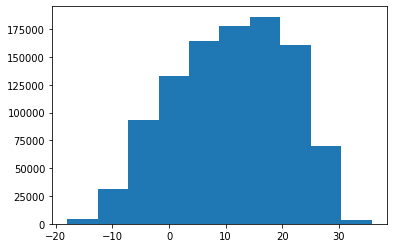

prec_L1_avg


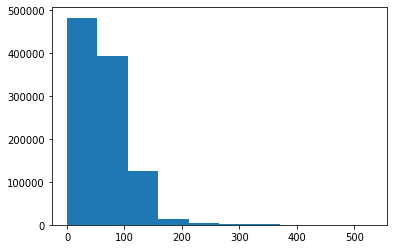

srad_L1_avg


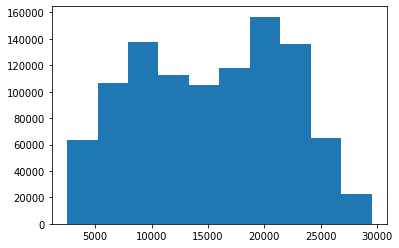

wind_L1_avg


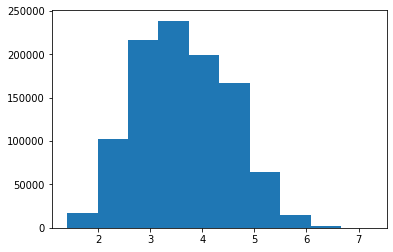

vapr_L1_avg


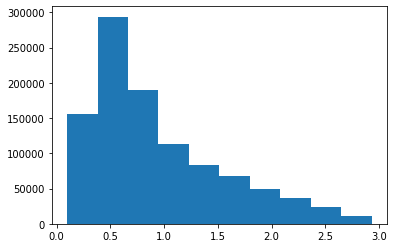

In [ ]:
for col in ['tavg_L1_avg', 'prec_L1_avg', 'srad_L1_avg', 'wind_L1_avg', 'vapr_L1_avg']:
  print(col)
  plt.hist(XTrain[col])
  plt.show()

From the above histograms, we can see that wind, solar radiation, and average temperature generally follow a normal-ish distribution so direct standardization should suffice. Average temperature is a stretch However, the other 3 variables show extreme skewness, especially precipitation. We would have to do something different with these variables.

A good idea is to use the Box-Cox transformation. This is a type of power transform that's designed to make data more Gaussian-like. However, the Box-Cox only works on strictly positive data. To handle our 0s and negative data, we'll use another one called **Yeo-Johnson** transformation.

The Yeo-Johnson isn't completely superior to Box-Cox, as interpretablitiy takes a huge hit with the former. However, we won't be examining the data after the fact anyway, so we're fine. Scikit-learn has the implementation.

#### Yeo-Johnson Transformation

In [ ]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
# We fit on the metrics...
metricPTData = pt.fit_transform(XTrain.loc[:, metricColumns])
XTrainPT = XTrain.copy()
XTrainPT.loc[:, metricColumns] = metricPTData
XTrainPT.head()

,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,LC23_L1_%,LC24_L1_%,LC31_L1_%,LC41_L1_%,LC42_L1_%,LC43_L1_%,LC52_L1_%,LC71_L1_%,LC81_L1_%,LC82_L1_%,LC90_L1_%,fires_L2_%,tavg_L2_avg,prec_L2_avg,srad_L2_avg,wind_L2_avg,vapr_L2_avg,LC11_L2_%,LC12_L2_%,LC21_L2_%,LC22_L2_%,LC23_L2_%,LC24_L2_%,LC31_L2_%,LC41_L2_%,LC42_L2_%,LC43_L2_%,LC52_L2_%,LC71_L2_%,LC81_L2_%,...,prec_L4_avg,srad_L4_avg,wind_L4_avg,vapr_L4_avg,LC11_L4_%,LC12_L4_%,LC21_L4_%,LC22_L4_%,LC23_L4_%,LC24_L4_%,LC31_L4_%,LC41_L4_%,LC42_L4_%,LC43_L4_%,LC52_L4_%,LC71_L4_%,LC81_L4_%,LC82_L4_%,LC90_L4_%,fires_L5_%,tavg_L5_avg,prec_L5_avg,srad_L5_avg,wind_L5_avg,vapr_L5_avg,LC11_L5_%,LC12_L5_%,LC21_L5_%,LC22_L5_%,LC23_L5_%,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%
590421,0.25,0.717322,-1.607143,1.467959,0.045338,0.113939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.25,0.00,0.0,0.0,0.750,0.661840,-1.580114,1.465667,0.082015,0.073186,0.000,0.0,0.000,0.0,0.0,0.0,0.25,0.000,0.000,0.000,0.75,0.000,0.00,...,-1.727821,1.467742,0.002637,0.191250,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.25,0.0000,0.0625,0.000,0.5625,0.1250,0.0000,0.0000,0.0,0.8,0.849667,-1.775783,1.462141,-0.049573,0.277223,0.00,0.0,0.00,0.05,0.05,0.0,0.1,0.0,0.05,0.05,0.45,0.15,0.0,0.10,0.00
551107,0.25,0.035012,-0.741661,1.113341,-0.450696,-0.068690,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.00,0.00,0.00,0.0,0.0,0.375,0.204201,-1.028412,1.134840,-0.427901,0.089441,0.000,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.250,0.125,0.50,0.125,0.00,...,-1.182274,1.151364,-0.406239,0.206232,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.00,0.0625,0.1875,0.000,0.4375,0.3125,0.0000,0.0000,0.0,0.6,0.375398,-1.136478,1.152242,-0.377032,0.247642,0.05,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.00,0.45,0.25,0.0,0.00,0.00
254538,0.00,-0.930255,-1.150888,-0.292139,0.774633,-1.040531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.75,0.00,0.0,0.0,0.000,-0.940832,-1.137915,-0.296015,0.785858,-1.058961,0.000,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.25,0.625,0.00,...,-1.154778,-0.295167,0.796873,-1.063481,0.0000,0.0,0.0000,0.0625,0.0,0.0,0.00,0.0000,0.0625,0.000,0.2500,0.3125,0.0000,0.3125,0.0,0.0,-0.950677,-1.172749,-0.292660,0.791191,-1.059870,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.10,0.00,0.45,0.40,0.0,0.05,0.00
1385667,0.00,-1.484961,-1.607143,-1.402182,1.157328,-1.409592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,0.00,0.0,0.0,0.000,-1.479671,-1.605552,-1.401658,1.145098,-1.410696,0.000,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.00,1.000,0.00,...,-1.602324,-1.400403,1.142905,-1.414981,0.1250,0.0,0.0000,0.0000,0.0,0.0,0.00,0.0000,0.0000,0.000,0.0000,0.8125,0.0625,0.0000,0.0,0.0,-1.451499,-1.594124,-1.400054,1.143664,-1.411100,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.90,0.0,0.00,0.00
346506,1.00,0.159397,1.450152,0.080257,-0.576562,0.272827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.00,0.25,0.25,0.0,0.0,1.000,0.162218,1.452766,0.079483,-0.578712,0.272663,0.125,0.0,0.125,0.0,0.0,0.0,0.00,0.125,0.125,0.125,0.00,0.000,0.25,...,1.458608,0.076834,-0.578201,0.271247,0.0625,0.0,0.0625,0.0000,0.0,0.0,0.00,0.1875,0.1250,0.125,0.0625,0.0625,0.3125,0.0000,0.0,1.0,0.162711,1.460107,0.077542,-0.582744,0.269780,0.05,0.0,0.05,0.00,0.00,0.0,0.0,0.2,0.20,0.10,0.05,0.10,0.2,0.00,0.05


tavg_L1_avg


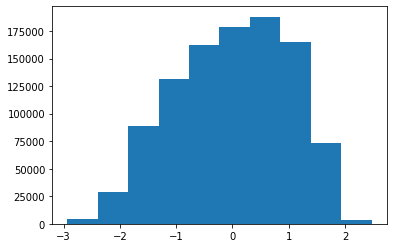

prec_L1_avg


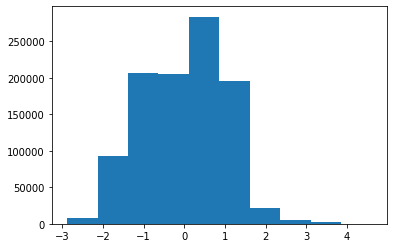

srad_L1_avg


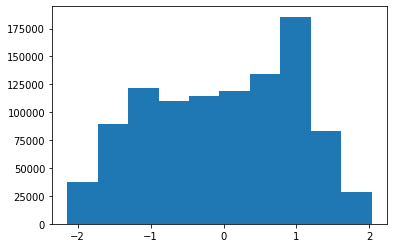

wind_L1_avg


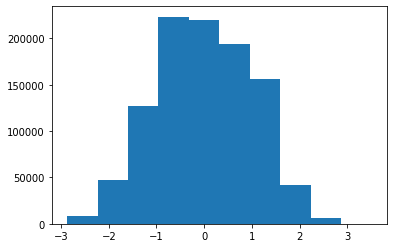

vapr_L1_avg


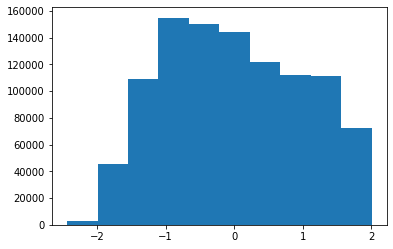

In [ ]:
for col in ['tavg_L1_avg', 'prec_L1_avg', 'srad_L1_avg', 'wind_L1_avg', 'vapr_L1_avg']:
  print(col)
  plt.hist(XTrainPT[col])
  plt.show()

The distributions look much better :) Next, we simply apply this to the validation and testing data!

#### Applying Transformation to Validation and Testing

In [ ]:
# Validation
metricPTData = pt.transform(XVali.loc[:, metricColumns])
XValiPT = XVali.copy()
XValiPT.loc[:, metricColumns] = metricPTData

# Testing
metricPTData = pt.transform(XTest.loc[:, metricColumns])
XTestPT = XTest.copy()
XTestPT.loc[:, metricColumns] = metricPTData

### Model Building
Our model will be simple: Just 3 Dense layers, and one output layer with 1 neuron, since we're doing binary classification. As with logistic regression, we'll start with lag 1 data, then do lag 5 data. Because the lag 5 data has more features, there will be more parameters in that model.

#### Lag of 1

In [ ]:
# Get columns for lag 1...
lag1Columns = [col for col in spatialReg.columns if 'L1' in col]
L1Train = XTrainPT.loc[:, lag1Columns]
L1Vali = XValiPT.loc[:, lag1Columns]
L1Test = XTestPT.loc[:, lag1Columns]
print('Number of features:', L1Train.shape[1])

Number of features: 21


With 21 features, our three layers can have 20, 15, and 10 neurons each.

In [ ]:
model = Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(21,)))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Output!

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                440       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 926
Trainable params: 926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(L1Train, YTrain, batch_size=64, epochs=20, validation_data=(L1Vali, YVali))

Epoch 1/20
16000/16000 [==============================] - 24s 2ms/step - loss: 0.3565 - acc: 0.8460 - val_loss: 0.3507 - val_acc: 0.8495
Epoch 2/20
16000/16000 [==============================] - 25s 2ms/step - loss: 0.3515 - acc: 0.8483 - val_loss: 0.3507 - val_acc: 0.8495
Epoch 3/20
16000/16000 [==============================] - 24s 2ms/step - loss: 0.3506 - acc: 0.8487 - val_loss: 0.3519 - val_acc: 0.8479
Epoch 4/20
16000/16000 [==============================] - 24s 2ms/step - loss: 0.3501 - acc: 0.8488 - val_loss: 0.3494 - val_acc: 0.8497
Epoch 5/20
16000/16000 [==============================] - 24s 2ms/step - loss: 0.3498 - acc: 0.8488 - val_loss: 0.3486 - val_acc: 0.8500
Epoch 6/20
16000/16000 [==============================] - 24s 2ms/step - loss: 0.3495 - acc: 0.8491 - val_loss: 0.3487 - val_acc: 0.8500
Epoch 7/20
16000/16000 [==============================] - 24s 2ms/step - loss: 0.3493 - acc: 0.8490 - val_loss: 0.3492 - val_acc: 0.8496
Epoch 8/20
16000/16000 [=================

Initial results are not encouraging...

In [ ]:
def reportStats(predictions, targets, return_vals=False):
  N = len(predictions)
  TP = sum((predictions == 1) & (targets == 1))
  TN = sum((predictions == 0) & (targets == 0))
  FP = sum((predictions == 1) & (targets == 0))
  FN = sum((predictions == 0) & (targets == 1))
  accuracy = (TP + TN) / N
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * precision * recall / (precision + recall)
  print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}'.format(accuracy, precision, recall, f1))
  if return_vals:
    return accuracy, precision, recall, f1

In [ ]:
predictions = model.predict(L1Test).ravel()
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

In [ ]:
reportStats(predictions, YTest)
print('All 0 accuracy:', 1 - np.mean(YTest))

Accuracy: 0.8490386751662024
Precision: 0.7656265676733219
Recall: 0.7055451540577399
F1: 0.7343590237095668
All 0 accuracy: 0.7042503375318305


Just barely better than our lag 1 in logistic regression. However, our F1 score is higher as well. Hopefully, I'll see a bigger improvement when using lag of 5

#### Lag of 5

There are 105 features here, thus we can make a bigger network. 75, 50, then 25.

In [ ]:
model5 = Sequential()
model5.add(layers.Dense(75, activation='relu', input_shape=(105,)))
model5.add(layers.Dense(50, activation='relu'))
model5.add(layers.Dense(25, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))  # Output!

model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 75)                7950      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model5.fit(XTrainPT, YTrain, batch_size=64, epochs=20, validation_data=(XValiPT, YVali))

Epoch 1/20
16000/16000 [==============================] - 29s 2ms/step - loss: 0.3255 - acc: 0.8568 - val_loss: 0.3272 - val_acc: 0.8569
Epoch 2/20
16000/16000 [==============================] - 29s 2ms/step - loss: 0.3254 - acc: 0.8570 - val_loss: 0.3283 - val_acc: 0.8568
Epoch 3/20
16000/16000 [==============================] - 29s 2ms/step - loss: 0.3253 - acc: 0.8569 - val_loss: 0.3271 - val_acc: 0.8571
Epoch 4/20
16000/16000 [==============================] - 29s 2ms/step - loss: 0.3252 - acc: 0.8570 - val_loss: 0.3271 - val_acc: 0.8565
Epoch 5/20
16000/16000 [==============================] - 29s 2ms/step - loss: 0.3250 - acc: 0.8571 - val_loss: 0.3273 - val_acc: 0.8571
Epoch 6/20
16000/16000 [==============================] - 29s 2ms/step - loss: 0.3249 - acc: 0.8571 - val_loss: 0.3270 - val_acc: 0.8565
Epoch 7/20
16000/16000 [==============================] - 29s 2ms/step - loss: 0.3248 - acc: 0.8572 - val_loss: 0.3276 - val_acc: 0.8572
Epoch 8/20
16000/16000 [=================

In [ ]:
predictions = model5.predict(XTest).ravel()
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

In [ ]:
reportStats(predictions, YTest)
print('All 0 accuracy:', 1 - np.mean(YTest))

ZeroDivisionError: ignored

In [ ]:
np.mean(predictions)

0.0

In [ ]:
model5.predict(XTrain).ravel()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)